In [169]:
%matplotlib inline
import os
import glob
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import oq_output.hazard_curve_converter as hc
import oq_output.disaggregation_converter as dc
mpl.rcParams['lines.linewidth'] = 2

In [31]:
CALCULATION_ID = 54
IML = 'SA-2.0'
POE = 0.1
path = 'calc_%d/disagg_matrix/%s' % (CALCULATION_ID, IML)
file_wild = '%s/disagg_matrix(%g)-*.xml' % (path, POE)
input_file_names = glob.glob(file_wild)
if len(input_file_names) > 0:
    print '%d files found.' % len(input_file_names) 
else:
    print 'No files found matching %s.' % path + file_wild
print 'Output path is %s.' % path

8 files found.
Output path is calc_54/disagg_matrix/SA-2.0.


In [196]:
metadata, matrices = dc.parse_nrml_disaggregation_file(input_file_name)
disag_types = [item[0] for item in matrices.items()]
print disag_types

['Dist', 'Mag,Dist', 'Lon,Lat,TRT', 'Mag', 'Lon,Lat', 'Mag,Dist,Eps', 'TRT', 'Mag,Lon,Lat']


In [195]:
disag_type = 'Mag,Dist,Eps'
for input_file_name in input_file_names:
    output_file_name = input_file_name.replace('.xml','.csv')
    dc.save_disagg_to_csv(input_file_name, path, False)
    csv_file = '%s/%s.csv' % (path, disag_type.replace(',', '_'))

In [192]:

x, y, z, p = np.loadtxt(csv_file, delimiter=',', skiprows=2, unpack=True)

x_axis = np.unique(x)
y_axis = np.unique(y)
z_axis = np.unique(z)

z = z.reshape((len(x_axis), len(y_axis), len(z_axis)))
i = list(z[0,0,:]).index(eps)  
z = z[:,:,i].flatten()
x = x.reshape((len(x_axis), len(y_axis), len(z_axis)))[:,:,i].flatten()
y = y.reshape((len(x_axis), len(y_axis), len(z_axis)))[:,:,i].flatten()
p = p.reshape((len(x_axis), len(y_axis), len(z_axis)))[:,:,i].flatten()

bin_width1 = np.diff(x_axis)[0] if len(x_axis) > 1 else 0
bin_width2 = np.diff(y_axis)[0] if len(y_axis) > 1 else 0
bin_width3 = np.diff(z_axis)[0] if len(z_axis) > 1 else 1

z_bin_edges = z_axis - bin_width3 / 2.
z_bin_edges = np.append(z_bin_edges, [z_axis[-1] + bin_width3 / 2.])

max_high = p.max()


                      
print x.shape, y.shape, z.shape, p.shape, (bin_width1*np.ones_like(x)).shape, (bin_width2*np.ones_like(x)).shape

(32,) (32,) (32,) (32,) (32,) (32,)


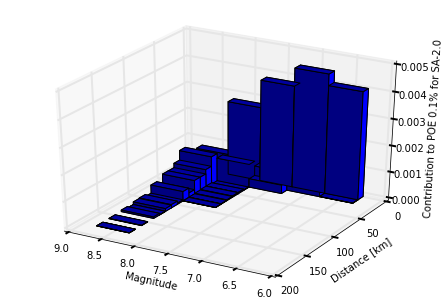

In [197]:
x = x[p != 0]
y = y[p != 0]
z = z[p != 0]
p = p[p != 0]


fig = plt.figure()
ax = Axes3D(fig)
h = ax.bar3d(x, y, np.zeros_like(x), bin_width1*np.ones_like(x), bin_width2*np.ones_like(x), p)
ax.invert_xaxis()
ax.invert_yaxis()
ax.set_xlabel('Magnitude')
ax.set_ylabel('Distance [km]')
ax.set_zlabel('Contribution to POE %g%% for %s' %(POE, IML))

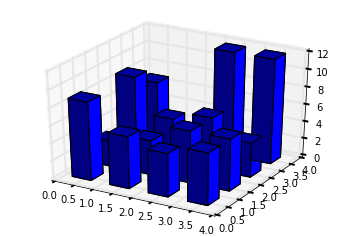

(4, 4) (16,) (16,) (16,) (16,) (16,) (16,)


In [173]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
x, y = np.random.rand(2, 100) * 4
hist, xedges, yedges = np.histogram2d(x, y, bins=4)

elements = (len(xedges) - 1) * (len(yedges) - 1)
xpos, ypos = np.meshgrid(xedges[:-1]+0.25, yedges[:-1]+0.25)

xpos = xpos.flatten()
ypos = ypos.flatten()
zpos = np.zeros(elements)
dx = 0.5 * np.ones_like(zpos)
dy = dx.copy()
dz = hist.flatten()

ax.bar3d(xpos, ypos, zpos, dx, dy, dz, color='b', zsort='average')

plt.show()
print hist.shape, xpos.shape, ypos.shape, zpos.shape, dx.shape, dy.shape, dz.shape

In [105]:
x_axis.shape

(7,)

In [65]:
def plot_1d_hist(hist_file, xlabel, title, annotation_file=None):
    """
    Plot 1D histogram
    """
    _, tail = os.path.split(hist_file)


    if tail == 'TRT.csv':
        data = np.loadtxt(hist_file, delimiter=',', skiprows=2, dtype=object)
        data = data.reshape(-1, 2)
        x = np.linspace(0, 1, data.shape[0])
        y = data[:, 1].astype(np.float)
        bin_width = 1
    else:
        data = np.loadtxt(hist_file, delimiter=',', skiprows=2)
        data = data.reshape(-1, 2)
        x = data[:, 0]
        y = data[:, 1]
        bin_width = np.diff(x)[0]

    region = '-R%s/%s/0/%s' % \
        (np.min(x) - bin_width, np.max(x) + bin_width, np.max(y))
    projection = '-JX15/15'
    annotation = '-B:%s:%s/:Probability:%s:.%s:WS' % \
        (xlabel, 2 * bin_width, np.round(np.max(y)/4, 4), title)

    if tail == 'TRT.csv':
        np.savetxt('trt_hist.dat', np.array([x, y], dtype=float).T)
        annotation = '-B:%s:/:Probability:%s:.%s:WS' % \
            (xlabel, np.round(np.max(y)/4, 4), title)


In [66]:
def plot_2d_hist(hist_file, xlabel, ylabel, title):
    """
    Plot 2D histogram
    """
    name = os.path.splitext(hist_file)[0]

    x, y, z = np.loadtxt(hist_file, delimiter=',', skiprows=2, unpack=True)
    bin_width1 = np.diff(np.unique(x))[0]
    bin_width2 = np.diff(np.unique(y))[0]

    # extract only non-zero z values
    idx = z > 0
    new_hist = np.concatenate(
        (x[idx].reshape(-1, 1), y[idx].reshape(-1, 1), z[idx].reshape(-1, 1)),
        axis=1
    )
    np.savetxt('new_hist.dat', new_hist)

    region = '-R%s/%s/%s/%s/%s/%s' % \
        (x[0] - bin_width1, x[-1] + bin_width1,
         y[0] - bin_width2, y[-1] + bin_width2,
         0.0, np.max(z))

    if 'Lon_Lat' in name:
        projection = '-Jx4d'
        annotation = '-B:%s:%s/:%s:%s/%s:Probability::.%s:WeSnZ' % \
            (xlabel, 3 * bin_width1, ylabel, 2 * bin_width2,
            np.round(np.max(z) / 4, 4), title)
    else:
        projection = '-JX15/15'
        annotation = '-B:%s:%s/:%s:%s/%s:Probability::.%s:wEsNZ' % \
            (xlabel, 2 * bin_width1, ylabel, 2 * bin_width2,
            np.round(np.max(z) / 4, 4), title)

In [140]:
def plot_3d_hist(hist_file, xlabel, ylabel, zlabel, title):
    """
    Plot 3d histogram
    """
    _, tail = os.path.split(hist_file)

    if tail == 'Lon_Lat_TRT.csv':
        x, y, p = np.loadtxt(
            hist_file, delimiter=',', skiprows=2, unpack=True, usecols=(0, 1, 3)
        )
        z = np.loadtxt(
            hist_file, delimiter=',', skiprows=2, unpack=True, usecols=(2,),
            dtype=str
        )
        x_axis = np.unique(x)
        y_axis = np.unique(y)
        z_axis = np.arange(len(np.unique(z)))
    else:
        x, y, z, p = np.loadtxt(
            hist_file, delimiter=',', skiprows=2, unpack=True
        )
        x_axis = np.unique(x)
        y_axis = np.unique(y)
        z_axis = np.unique(z)

    p = p.reshape((len(x_axis), len(y_axis), len(z_axis)))

    bin_width1 = np.diff(x_axis)[0] if len(x_axis) > 1 else 0
    bin_width2 = np.diff(y_axis)[0] if len(y_axis) > 1 else 0
    bin_width3 = np.diff(z_axis)[0] if len(z_axis) > 1 else 1

    z_bin_edges = z_axis - bin_width3 / 2.
    z_bin_edges = np.append(z_bin_edges, [z_axis[-1] + bin_width3 / 2.])

    max_high = np.max(np.sum(p, axis=2))

    # modify cpt file to create custom annotation
    if tail == 'Lon_Lat_TRT.csv':
        cpt_table = np.loadtxt('colors.cpt')
        if len(cpt_table.shape) == 1:
            cpt_table = cpt_table.reshape(-1, cpt_table.size)
        annotations = np.array([';%s' % trt for trt in np.unique(z)])
        annotations = annotations.reshape(-1, 1)
        annotations = annotations.astype(object)
        cpt_table = np.concatenate((cpt_table, annotations), axis=1)
        cpt = open('colors.cpt', 'w')
        for (v1, r1, g1, b1, v2, r2, g2, b2, label) in cpt_table:
            cpt.write('%f %i %i %i %f %i %i %i %s\n' %
                      (v1, r1, g1, b1, v2, r2, g2, b2, label))
        cpt.close()

    if 'Lon_Lat' in tail:
        projection = '-Jx4d'
        annotation = '-B:%s:%s/:%s:%s/%s:Probability::.%s:WeSnZ' % \
            (xlabel, 3 * bin_width1, ylabel, 2 * bin_width2,
            np.round(np.max(max_high) / 4, 4), title)
        for i, v1 in enumerate(x_axis):
            for j in range(len(y_axis))[::-1]:
                v2 = y_axis[j]
                for k, v3 in enumerate(z_axis):

                    if k == 0:
                        base_hight = 0.
                    else:
                        base_hight = np.sum(p[i, j, :k])

                    f = open('values.dat', 'w')
                    f.write('%s %s %s %s' % (v1, v2, base_hight + p[i, j, k], v3))
                    f.close()

    else:
        projection = '-JX15/15'
        annotation = '-B:%s:%s/:%s:%s/%s:Probability::.%s:wEsNZ' % \
            (xlabel, 2 * bin_width1, ylabel, 2 * bin_width2,
            np.round(max_high / 4, 4), title)

        first = False
        for i, v1 in enumerate(x_axis):
            for j, v2 in enumerate(y_axis):
                for k, v3 in enumerate(z_axis):

                    if k == 0:
                        base_hight = 0.
                    else:
                        base_hight = np.sum(p[i, j, :k])

                    f = open('values.dat', 'w')
                    f.write('%s %s %s %s' % (v1, v2, base_hight + p[i, j, k], v3))
                    f.close()

SyntaxError: invalid syntax (<ipython-input-140-4384fcfc546c>, line 7)

In [63]:
def plot_hist(output_file, disag_type):
    if disag_type == 'Mag':
        plot_1d_hist(output_file, 'Magnitude', '')
    elif disag_type == 'Dist':
        plot_1d_hist(output_file, 'JB distance', '')
    elif disag_type == 'TRT':
        ntrt = metadata['TRT'].size
        bin_edges = range(ntrt)
        annotation_file = open("annotation.dat",'w')
        for i in range(ntrt):
            annotation_file.write("%s %s %s %s %s %s %s\n" % 
                (bin_edges[i],
                numpy.max(matrix) + 0.05 * numpy.max(matrix),
                12, 0.0, 0, 'MC', metadata['TRT'][i]))
        annotation_file.close()
        plot_1d_hist(output_file, 'Tectonic Region',
                     '', annotation_file.name)
    elif disag_type == 'Mag,Dist':
        plot_2d_hist(output_file, 'Magnitude', 'JB distance', '')
    elif disag_type == 'Lon,Lat':
        plot_2d_hist(output_file, 'Longitude', 'Latitude', '')
    elif disag_type == 'Mag,Dist,Eps':
        plot_3d_hist(output_file, 'Magnitude', 'Distance', 'Epsilon', '')
    elif disag_type == 'Lon,Lat,Eps':
        plot_3d_hist(output_file, 'Longitude', 'Latitude', 'Epsilon', '')
    elif disag_type == 'Lon,Lat,Mag':
        plot_3d_hist(output_file, 'Longitude', 'Latitude', 'Magnitude', '')
    elif disag_type == 'Lon,Lat,TRT':
        plot_3d_hist(output_file, 'Longitude', 'Latitude', '', '')